README -- Out of memory errors <br>
This code is tuned for a RTX3060 12GB, if you have less memory, you will likely get "out of memory" errors with this code, try to aggressively reduce batch size (you can increase epochs to compensate)

### A Parallel Approach to Sequence Modeling

By leveraging the sequence length as a batch dimension, applying a linear layer to all embeddings on the GPU becomes highly efficient. In the attention mechanism, this process is repeated three times, yielding: 

**Keys**, **Queries**, **Values** -- Each of these has the shape `(batch_size, sequence_length, embedding_size)`.

We then multiply the keys and queries (transposed), resulting in a similarity matrix of size `(batch_size, sequence_length, sequence_length)`. This matrix indicates how much each token attends to (or is interested in) every other token. Subsequently, we multiply this matrix by the values and sum the results.

The core idea is that by constructing a similarity matrix, we can identify dependencies and use the values to update words with their new semantic meanings. For example, the word "apple" can refer to both a fruit and a technology company, the attention mechanism allows its meaning to be inferred from other words.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import LucaM185 
device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")


In [2]:
with open("datasets/enwik8", "r") as f:
    load = f.read()
print(load[:200])

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/


In [3]:
class MyInputs:
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        start_indices = idx.unsqueeze(1) + torch.arange(self.sequence_length)
        return self.data[start_indices]


In [4]:
# Restricting to ASCII characters
texttoint = {chr(i): i for i in range(256)}
inttotext = {i: chr(i) for i in range(256)}
dataset = torch.tensor([texttoint[c] for c in load if c in texttoint])

vocab_size = len(texttoint)
sequence_length = 20
val_set = int(len(dataset)*0.1)

inputs = MyInputs(dataset[val_set:-1-sequence_length], sequence_length)
labels = MyInputs(dataset[val_set+1:-sequence_length], sequence_length)
val_inputs = MyInputs(dataset[:val_set], sequence_length)
val_labels = MyInputs(dataset[1:val_set+1], sequence_length)

print(len(dataset))

99757179


Millions of parameters: 0.37
Epoch ___0 - Loss: 5.539 - Val Loss: 5.533
Epoch __30 - Loss: 3.753 - Val Loss: 3.541
Epoch __60 - Loss: 3.401 - Val Loss: 3.498
Epoch __90 - Loss: 3.364 - Val Loss: 3.211
Epoch _120 - Loss: 3.214 - Val Loss: 3.145
Epoch _150 - Loss: 2.988 - Val Loss: 3.062
Epoch _180 - Loss: 2.922 - Val Loss: 2.973
Epoch _210 - Loss: 2.815 - Val Loss: 2.686
Epoch _240 - Loss: 2.734 - Val Loss: 2.784
Epoch _270 - Loss: 2.718 - Val Loss: 2.755


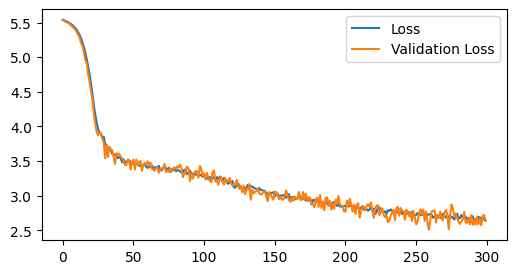

In [5]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) # this is a list of linear layers
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden:    # iterating over hidden layers
            x = F.gelu(hidden(x))  # applying each hidden layer
        return self.fc_out(x)

model = Model(emb_size=32, hidden_size=256, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 300
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes][:, -1].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred, val_labels[indexes][:, -1].to(device))
        vlossi.append(vloss.item())
        
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")
    

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Limiting our dataset to ascii characters only reduces the size by 0.3% so we should be fine

# Attention Block - Scaled dot product attention

Scaled Dot-Product Attention allows a model to focus on different parts of an input sentence by comparing each word to every other word. It works by turning the input sentence into three types of information: **queries (Q)**, **keys (K)**, and **values (V)**, which are all derived from the same sentence. The queries and keys are compared to see which words are most relevant to each other. 

The model then calculates how much attention each word should give to others, based on these comparisons. To make sure the calculations are stable, we scale the comparisons and then turn them into probabilities. The result is a weighted sum of the values, which helps the model focus on the most important parts of the sentence.

This method compares every word with every other word, so it can become slow as the sentence gets longer, requiring more calculations. Actually if we want to use the better way of predicting tokens at each timestep from the RNN, we need to make sure that in the attention mechanism, past tokens can't get information from future ones, we do this by zeroing out the values with a tril matrix like this:


```
[ 1,  0,  0,  0 ]
[ 1,  1,  0,  0 ]
[ 1,  1,  1,  0 ]
[ 1,  1,  1,  1 ]
```


In [5]:
class Attention(nn.Module):  
    def __init__(self, emb_size):
        super(Attention, self).__init__()
        self.emb_size = emb_size

        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size) 

    def forward(self, x):
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)
        similarity = k @ q.transpose(-2, -1)/(self.emb_size**0.5)

        # By masking the attention we make sure that current tokens can't see future tokens, this allows us to train
        # the model with the entire sequence instead of a single token at a time. We call this "casual" attention
        similarity[torch.tril(torch.ones_like(similarity)) == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = -1)

        attention = similarity @ v 
        return attention


class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x


class Wrapper(nn.Module): 
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

        self.fcout = nn.Linear(emb_size, vocab_size)

    def forward(self, x):          
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device)) 
        x = x + self.att(self.prenorm1(x)) 
        x = x + self.fc(self.prenorm2(x))
        x = self.fcout(x)
    
        return x


Millions of parameters: 0.60
Epoch ___0 - Loss: 5.973 - Val Loss: 5.878
Epoch __60 - Loss: 3.089 - Val Loss: 3.062
Epoch _120 - Loss: 2.824 - Val Loss: 2.773
Epoch _180 - Loss: 2.641 - Val Loss: 2.706
Epoch _240 - Loss: 2.532 - Val Loss: 2.504
Epoch _300 - Loss: 2.487 - Val Loss: 2.555
Epoch _360 - Loss: 2.446 - Val Loss: 2.476
Epoch _420 - Loss: 2.422 - Val Loss: 2.511
Epoch _480 - Loss: 2.384 - Val Loss: 2.360
Epoch _540 - Loss: 2.398 - Val Loss: 2.353


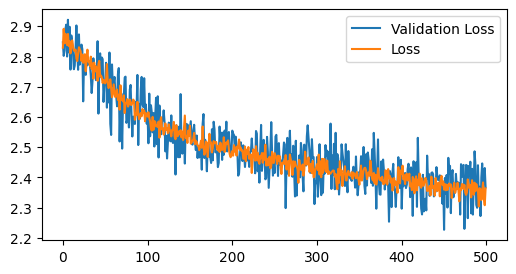

In [7]:
model = Wrapper(vocab_size=vocab_size, emb_size=256, hidden_size=256, n_layers=2).to(device)
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 600
batch_size = 512
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))

        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")
    
plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

This performance is slightly worse than 20 layers MLP, but we are using just a single block (attention + 2 hidden layer MLP)  <br>
Note: we are using roughly 20k parameters instead of 370k

In [8]:
string = '\n<mediawiki xmlns="http://www.media'
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred[0, -1, :], dim=0), 1).item()]
        print(string[-1], end="")



<mediawiki xmlns="http://www.mediany. Xentions whe of arsoungepsoont thovity:Tadime nereramots sve mestreamppes to seorenng (3000000''''''ch farchodof rogy ar witiony]] Frestom tenay useresiur:Eowe Dusyar]] (18/,&queft;nt rent, Ry, Afroverconirical iecatuas wor the curente in the comons'' a Gone sed [[Intacy]]
[[Bretiosp&quot;2000-R

# Transformers 

Transformers consist of many attention blocks and MLPs in sequence, with residual connections 

In [6]:
class Block(nn.Module): 
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):
        x = x + (self.att(self.prenorm1(x)))
        x = x + (self.fc(self.prenorm2(x)))
    
        return x

class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        
        self.blocks = nn.ModuleList([Block(emb_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = (self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))) 

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x


In [179]:
model = Transformer(vocab_size=vocab_size, emb_size=256, n_blocks=4, head_size=256, hidden_size=256, n_layers=2).to(device)
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 400 # Tailored to be time-comparable to the MLP
batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.03) 

lossi = []
vlossi = []

for epoch in range(epochs):
    model.train()
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        model.eval()
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

TypeError: __init__() takes 2 positional arguments but 5 were given

In [11]:
string = '\n<mediawiki xmlns="http://www.media'
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred[0, -1, :], dim=0), 1).item()]
        print(string[-1], end="")




<mediawiki xmlns="http://www.mediary)''T. The Crot it tereny (angorder-271001L63]]&amp;|-2, WM Cent's is the by on the [[crement]] [[Catweonaidourar a pregolded exply bectdr, the name aciblan [[Nikegath sts proted maes, the Cobjonehthat in luspses somintand pheristinckilus ratiegion contelus bouse tevise or and ware at the Fore_arly

# Speed
Attention feels pretty slow, because it's quadratic in complexity, but if you think about it, for large N, (N-1)^2 of the similarity matrix is the same as the one in t-1. So we only need roughly 2*N computations to complete the matrix. 

Furthermore since we use self attention with a mask, roughly 50% of the matrix is useless... So we only need N computations to do the incremental step in inference to add a new token